In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from global_land_mask import globe

In [2]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K

### PPE

In [2]:
enn = np.arange(0,174)

In [3]:
for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']:
        d_path = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.'+f'{en:03d}'+'/atm/hist/cc_PPE_250_ensemble_PD.'+f'{en:03d}'+'.h0.'+str(i)+'.nc'
        data =xr.open_dataset(d_path)
        
        if en == 0:
            lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
            lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
            time = data.variables['time'][:] #(time: 36)
            
        locals()[str(en)+'_'+i] = data.variables[i][:]

In [4]:
x_lat = np.array(lat)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]
lat_new  = lat[lat_ind1[0]:lat_ind2[0]]

mask = np.ones((36,len(lat_new),len(lon)))

for a in range(len(lat_new)):
    for b in range(len(lon)):
        if globe.is_land(lat_new[a], lon[b]-180.)==True:
            mask[0:35,a,b] = 0

for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']: #
        tmp  = locals()[str(en)+'_'+i]
        tmp2 = tmp[:,lat_ind1[0]:lat_ind2[0],:]
        locals()['MID'+i+'_'+str(en)] = np.multiply(mask,tmp2)

In [6]:
for en in enn:
    locals()['theta_850_'+str(en)] = np.multiply(locals()['MIDT850_'+str(en)],(np.divide(locals()['MIDPSL_'+str(en)],85000))**(Rd/Cp))

In [7]:
for en in enn:
    locals()['M_'+str(en)]   = np.array(np.subtract(locals()['MIDTS_'+str(en)],locals()['theta_850_'+str(en)])).reshape(-1)
    locals()['U10_'+str(en)] = np.array(locals()['MIDU10_'+str(en)]).reshape(-1)

In [8]:
from scipy import stats
from skmisc.loess import loess
for en in enn:
    bin_means, bin_edges, binnumber = stats.binned_statistic(locals()['M_'+str(en)], locals()['U10_'+str(en)], 'mean', bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    x = np.array(bin_centers[:])
    y = np.array(bin_means[:])
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]

    l = loess(xx,yy)
    l.fit()
    pred = l.predict(xx, stderror=True)
    conf = pred.confidence()

    locals()['lowess_'+str(en)] = pred.values
    ll = conf.lower
    ul = conf.upper
    locals()['xx_'+str(en)] = xx

### MACLWP + MERRA2 REANALYSIS

In [2]:
import glob
merlist = np.sort(glob.glob('../data_merra/lat_30_70/MERRA2_*.nc'))
maclist = np.sort(glob.glob('../MACLWP_dailymean/take/wind1deg*.nc4'))

In [3]:
for i in range(len(merlist)): #len(maclist)
    d_path = merlist[i]
    data   = nc.Dataset(d_path)
    merlat = data.variables['lat'][:]
    merlon = data.variables['lon'][:]
    merlev = data.variables['lev'][:]
    merU   = data.variables['U'][:]
    merV   = data.variables['V'][:]
    merT   = data.variables['T'][:]
    
    ddpath = maclist[i]
    ddata  = nc.Dataset(ddpath)
    macw   = ddata.variables['sfcwind'][:]
    maclat = ddata.variables['lat'][:]
    maclon = ddata.variables['lon'][:]
    

    

In [5]:
print(np.shape(merlon),np.shape(maclon))
print(np.shape(merlat),np.shape(maclat))

(576,) (360,)
(81,) (180,)


In [6]:
maclon = maclon-180.
maclon[maclon > 180] = maclon[maclon > 180]-360

In [7]:
sx_lat = np.array(maclat)
slat_ind1 = np.where(sx_lat == sx_lat.flat[np.abs(sx_lat - (30)).argmin()])[0]
slat_ind2 = np.where(sx_lat == sx_lat.flat[np.abs(sx_lat - (70)).argmin()])[0]
p_maclat  = np.array(maclat[slat_ind1[0]:slat_ind2[0]])
plot_maclat = p_maclat[1::]
plot_merlat = np.array(merlat[1:-3:2])

In [8]:
plot_maclon = []
plot_merlon = []
plot_merT = []
plot_merTsfc = []

for i in range(len(maclon)):
    da = np.abs(merlon-maclon[i])
    idx = np.argmin(da.data)
    plot_merlon.append(merlon[idx])
    plot_merT.append(merT[0,1,1:-3:2,idx])
    plot_merTsfc.append(merT[0,0,1:-3:2,idx])
    
plot_maclon = np.array(maclon)
plot_merlon = np.array(plot_merlon)
plot_merT = np.array(plot_merT)
mertheta = np.transpose(np.subtract(plot_merTsfc, 
                       np.multiply(plot_merT, (100/85)**(Rd/Cp))))
mwind = macw[14,slat_ind1[0]:slat_ind2[0],:]
macwind = mwind[1::,:]

In [9]:
print(np.shape(plot_merlat),np.shape(plot_merlon))
print(np.shape(plot_maclat),np.shape(plot_maclon))
print(np.shape(mertheta))
print(np.shape(macwind))

(39,) (360,)
(39,) (360,)
(39, 360)
(39, 360)


In [10]:
plot_mac_wind  = []
plot_mer_theta = []

for i in range(len(merlist)):#len(merlist)
    if i==0:
        maskm = np.ones((len(plot_merlat),len(plot_merlon)))

        for a in range(len(plot_merlat)):
            for b in range(len(plot_merlon)):
                if globe.is_land(plot_merlat[a], plot_merlon[b])==True:
                    maskm[a,b] = 0
    
    # merw     = np.sqrt(np.add(merU[0,0,:,:]**2, merV[0,0,:,:]**2))
    plot_mertheta = np.array(np.multiply(maskm,mertheta)).reshape(-1)
    plot_macwind = np.array(np.multiply(maskm,macwind)).reshape(-1)
    
    test_nan = np.array(np.multiply(plot_macwind, plot_mertheta))
    
    plot_mac_wind.extend(plot_macwind[(test_nan<3000) & (test_nan>(-3000)) & (plot_macwind>0)])
    plot_mer_theta.extend(plot_mertheta[(test_nan<3000) & (test_nan>(-3000)) & (plot_macwind>0)])
    
plot_mac_wind = np.array(plot_mac_wind)
plot_mer_theta = np.array(plot_mer_theta)

In [11]:
print(np.shape(plot_mac_wind),np.shape(plot_mer_theta))

(85608,) (85608,)


In [17]:
from scipy import stats
from skmisc.loess import loess

bin_means, bin_edges, binnumber = stats.binned_statistic(plot_mer_theta, plot_mac_wind, 'mean', bins=200)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

mac_bin_means = bin_means[~np.isnan(bin_means)]
mac_bin_centers = bin_centers[~np.isnan(bin_means)]

x = np.array(mac_bin_centers[:])
y = np.array(mac_bin_means[:])
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

l = loess(xx,yy)
l.fit()
pred = l.predict(xx, stderror=True)
conf = pred.confidence()

macloess = pred.values
ll = conf.lower
ul = conf.upper
finaltheta = xx

### PLOT

(3.0, 13.0)

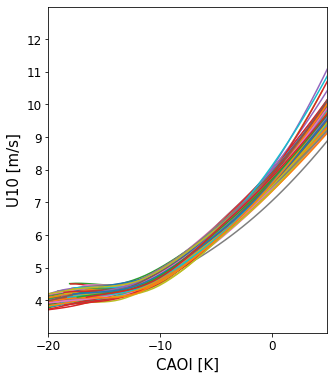

In [70]:
fig= plt.figure(figsize=(5, 6))
for en in enn:
    plt.plot(locals()['xx_'+str(en)], locals()['lowess_'+str(en)])
    
# plt.scatter(macxx, macloess, label = 'MERRA2')
# plt.title('PPE U10 vs Cold air outbreak index\n30N to 70N excluding land for \n175 ensembles(solid) and MACLWP+MERRA2(scatter)')
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.xticks([-20,-10,0],fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
# plt.savefig('/glade/u/home/geethma/link/GCMres/ppeU10vsMwithMACLWP.png')
# plt.legend(fontsize=12.0,frameon=False)
# plt.text(-47, 13, 'Solid lines - PPE', fontsize=12.0)

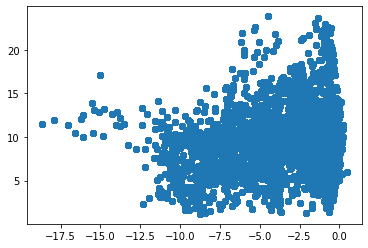

In [15]:

plt.scatter(plot_mer_theta, plot_mac_wind)

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')

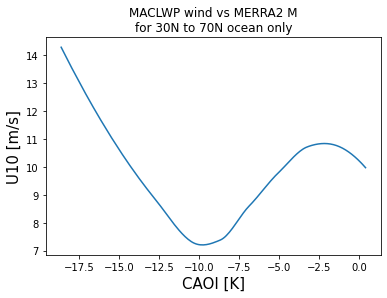

In [21]:
plt.plot(finaltheta, macloess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')
# plt.xticks([-20,-10,0],fontsize='12')
# plt.yticks(np.arange(4,13),fontsize='12')
# plt.xlim([-20,5])
# plt.ylim([3,13])

In [10]:
np.shape(macw)

(31, 180, 360)

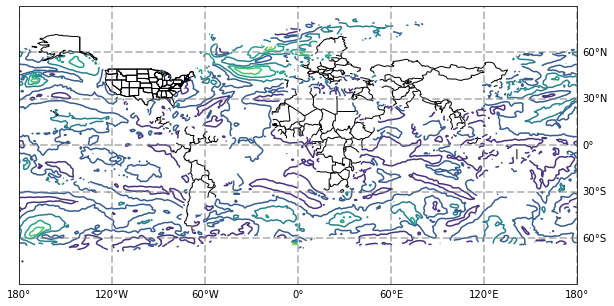

In [17]:
from cartopy import crs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs.PlateCarree())
scatter = ax.contour(maclon, maclat,macw[14,:,:])
gl = ax.gridlines(draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
# plt.clabel(ax, inline=True, fontsize=10)
gl.xlabels_top = False
gl.ylabels_left = False


ax.add_feature(cfeature.STATES , linewidth=1, alpha=1, edgecolor='black')
ax.add_feature(cfeature.BORDERS , linewidth=1, alpha=1, edgecolor='black')
# ax.add_feature(cfeature.COUNTRY , linewidth=1, alpha=1, edgecolor='black')



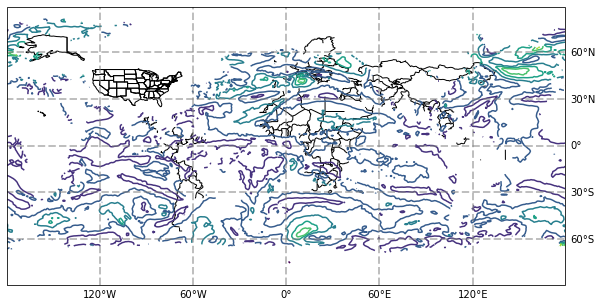

In [18]:
from cartopy import crs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs.PlateCarree())
scatter = ax.contour(maclon-180., maclat,macw[14,:,:])
gl = ax.gridlines(draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
# plt.clabel(ax, inline=True, fontsize=10)
gl.xlabels_top = False
gl.ylabels_left = False


ax.add_feature(cfeature.STATES , linewidth=1, alpha=1, edgecolor='black')
ax.add_feature(cfeature.BORDERS , linewidth=1, alpha=1, edgecolor='black')